In [11]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import zoom, rotate
from tqdm import tqdm

In [12]:
# segmentation
file_path = '../../data/PETCT_5d10be5b89/05-30-2005-NA-PET-CT Ganzkoerper  primaer mit KM-53829/SEG.nii.gz'
#file_path = '../data/sub-data/PETCT_0af7ffe12a/08-12-2005-NA-PET-CT Ganzkoerper  primaer mit KM-96698/SEG.nii.gz'
#file_path = '../data/sub-data/PETCT_fe705ea1cc/12-29-2002-NA-Unspecified CT ABDOMEN-93772/SEG.nii.gz'
#file_path = '../data/sub-data/PETCT_fe705ea1cc/12-29-2002-NA-Unspecified CT ABDOMEN-93772/SEG.nii.gz'
output_path = '../../outputs/SEG_rotations_4.png'
output3D_path = '../../outputs/3D_segmentation_4rotations.png'

# PET SUV
#file_path = '../../data/PETCT_5d10be5b89/05-30-2005-NA-PET-CT Ganzkoerper  primaer mit KM-53829/SUV.nii.gz'
#file_path = '../data/sub-data/PETCT_0af7ffe12a/08-12-2005-NA-PET-CT Ganzkoerper  primaer mit KM-96698/SUV.nii.gz'
#file_path = '../data/sub-data/PETCT_fe705ea1cc/12-29-2002-NA-Unspecified CT ABDOMEN-93772/SUV.nii.gz'
#file_path = '../data/sub-data/PETCT_fe705ea1cc/12-29-2002-NA-Unspecified CT ABDOMEN-93772/SUV.nii.gz'
#output_path = '../../outputs/SUV_rotations.png'

# CT
#file_path = '../data/sub-data/PETCT_5d10be5b89/05-30-2005-NA-PET-CT Ganzkoerper  primaer mit KM-53829/CTres.nii.gz'
#file_path = '../data/sub-data/PETCT_0af7ffe12a/08-12-2005-NA-PET-CT Ganzkoerper  primaer mit KM-96698/CTres.nii.gz'
#file_path = '../data/sub-data/PETCT_fe705ea1cc/12-29-2002-NA-Unspecified CT ABDOMEN-93772/CTres.nii.gz'
#file_path = '../data/sub-data/PETCT_fe705ea1cc/12-29-2002-NA-Unspecified CT ABDOMEN-93772/CTres.nii.gz'

mode = 'segmentation'  # "PET" or "segmentation" --> This will determine the colormap for visualization
if mode == 'segmentation':
        cmap = 'gray'
elif mode == 'PET':
    cmap = 'hot'

n_mips_per_axis = 4  #should be exponent of 2

# functions

In [13]:
def visualize_slice(img, slice_number):
    plt.imshow(rotate(img[slice_number,:,:], 90, axes=(0,1), reshape=False, order=0, mode='nearest'),
               cmap=cmap)
    plt.show()
    plt.imshow(rotate(img[:,slice_number,:], 90, axes=(0,1), reshape=False, order=0, mode='nearest'),
               cmap=cmap)
    plt.show()
    plt.imshow(rotate(img[:,:,slice_number], 90, axes=(0,1), reshape=False, order=0, mode='nearest'),
               cmap=cmap)
    plt.show()


def dice_score(gt, pred):
    epsilon = 1e-5
    numerator = 2 * ((gt * pred).sum())
    denominator = gt.sum() + pred.sum() + epsilon
    dice = numerator / denominator
    return dice

# main codes

(400, 400, 296)
[-1.       2.03642  2.03642  3.       1.       1.       1.       1.     ]
0.0 1.0
(400, 400, 436)


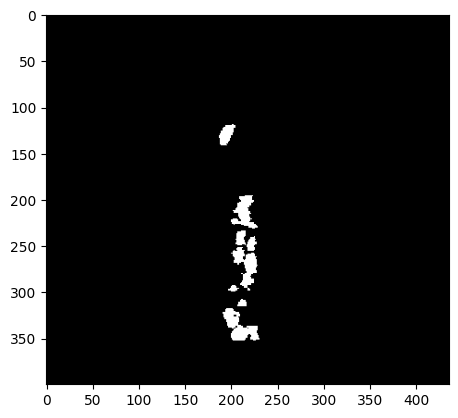

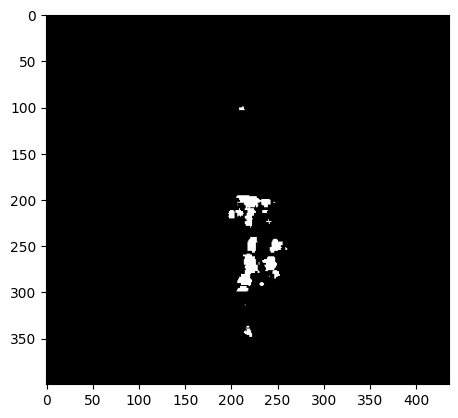

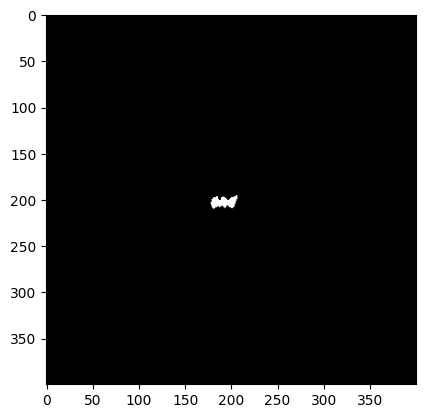

In [14]:
data = nib.load(file_path)
# Convert the image data to a numpy array
img = data.get_fdata()
print(img.shape)
print(data.header['pixdim'])
print(img.min(), img.max())

# x is horizontal dimension when view cross sectional image
# y is vertical dimension when view cross sectional image
# z is height dimension of the patient
x,y,z = img.shape
x_scale, y_scale, z_scale = data.header['pixdim'][1:4]
min_scale = min(x_scale, y_scale, z_scale)
x_scale /= min_scale
y_scale /= min_scale
z_scale /= min_scale

img = zoom(img, (x_scale, y_scale, z_scale), order=0)  
#Spline order 0 is equivalent to nearest neighbor interpolation.
print(img.shape)

visualize_slice(img, slice_number=200)

# MIPs with rotations

0.0 1.0


4it [00:32,  8.06s/it]
4it [00:13,  3.39s/it]
4it [00:14,  3.58s/it]


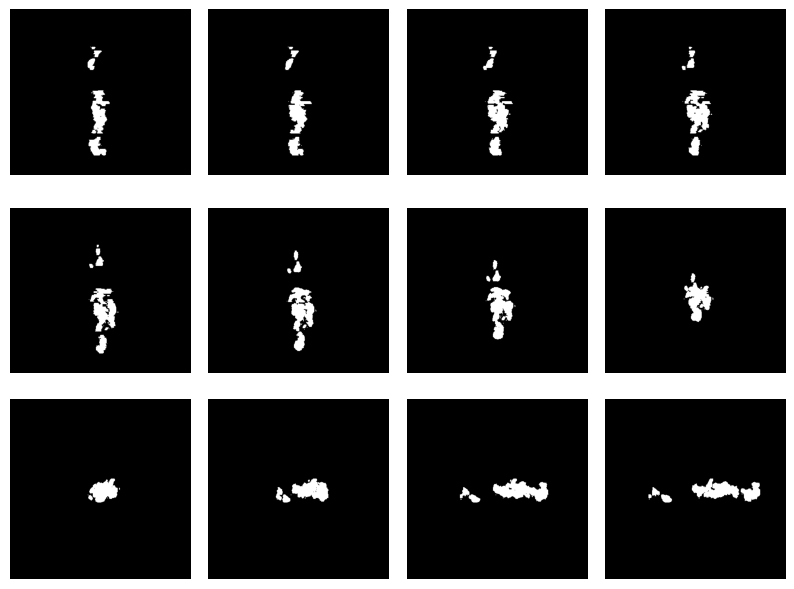

In [15]:
print(img.min(), img.max())
x,y,z = img.shape

mips = {'x':{}, 'y':{}, 'z':{}}

fig, ax = plt.subplots(3, n_mips_per_axis, figsize=(10,7.5))

#rotate on the x,y plane, and take MIP along x axis
for i,angle in tqdm(enumerate(np.linspace(0, 90, num=n_mips_per_axis, endpoint=False))):
    rotated_img = rotate(img, angle, axes=(0,1), reshape=False,
                        order=0, mode='constant', cval=0.0)
    mip = np.max(rotated_img, axis=0)
    mips['x'][angle] = mip
    ax[0,i].imshow(rotate(mip, 90, axes=(0,1), reshape=False, order=0),
                    cmap=cmap)
    ax[0,i].axis('off')

#rotate on the y,z plane, and take MIP along y axis
for i,angle in tqdm(enumerate(np.linspace(0, 90, num=n_mips_per_axis, endpoint=False))):
    rotated_img = rotate(img, angle, axes=(1,2), reshape=False,
                        order=0, mode='constant', cval=0.0)
    mip = np.max(rotated_img, axis=1)
    mips['y'][angle] = mip
    ax[1,i].imshow(rotate(mip, 90, axes=(0,1), reshape=False, order=0),
                    cmap=cmap)
    ax[1,i].axis('off')

#rotate on the z,x plane, and take MIP along z axis
for i,angle in tqdm(enumerate(np.linspace(0, 90, num=n_mips_per_axis, endpoint=False))):
    rotated_img = rotate(img, angle, axes=(2,0), reshape=False,
                        order=0, mode='constant', cval=0.0)
    mip = np.max(rotated_img, axis=2)
    mips['z'][angle] = mip
    ax[2,i].imshow(rotate(mip, 90, axes=(0,1), reshape=False, order=0),
                    cmap=cmap)
    ax[2,i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig(output_path)
plt.show()

# Reconstruction of segmentation masks

In [16]:
recon_seg = np.ones(img.shape)

#broadcast on the x axis, then "reverse rotate" along x,y axis
for angle in tqdm(np.linspace(0, 90, num=n_mips_per_axis, endpoint=False)):
    broadcast_mip = np.broadcast_to(mips['x'][angle][np.newaxis,:,:], img.shape)
    reverse_rotate = rotate(broadcast_mip, 360-angle, axes=(0,1), reshape=False,
                            order=0, mode='constant', cval=0.0)
    recon_seg *= reverse_rotate

#broadcast on the y axis, then "reverse rotate" along y,z axis
for angle in tqdm(np.linspace(0, 90, num=n_mips_per_axis, endpoint=False)):
    broadcast_mip = np.broadcast_to(mips['y'][angle][:,np.newaxis,:], img.shape)
    reverse_rotate = rotate(broadcast_mip, 360-angle, axes=(1,2), reshape=False,
                            order=0, mode='constant', cval=0.0)
    recon_seg *= reverse_rotate

#broadcast on the z axis, then "reverse rotate" along z,x axis
for angle in tqdm(np.linspace(0, 90, num=n_mips_per_axis, endpoint=False)):
    broadcast_mip = np.broadcast_to(mips['z'][angle][:,:,np.newaxis], img.shape)
    reverse_rotate = rotate(broadcast_mip, 360-angle, axes=(2,0), reshape=False,
                            order=0, mode='constant', cval=0.0)
    recon_seg *= reverse_rotate
    

100%|██████████| 4/4 [00:12<00:00,  3.07s/it]


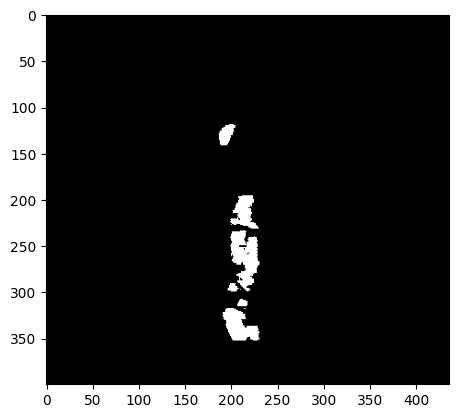

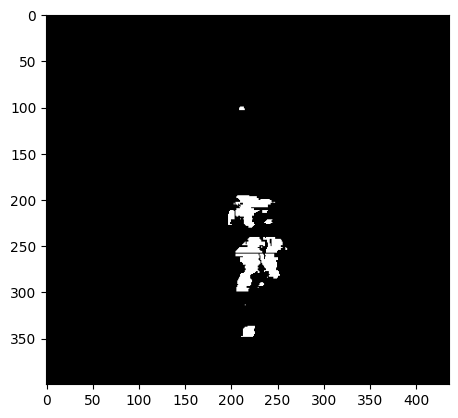

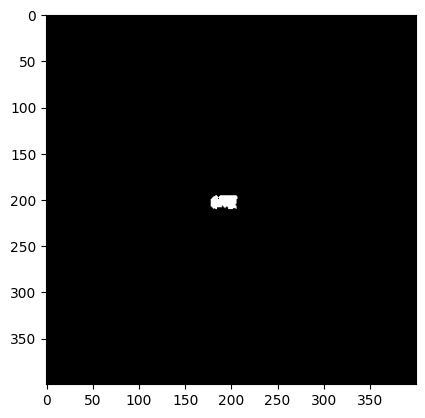

In [17]:
visualize_slice(recon_seg, slice_number=200)

# Dice score

In [18]:
dice_score(img, recon_seg)

0.8150964323429757

# 3D plot

In [19]:
#need to resize the img for 3D plotting because it consumes much memory
img_plot = zoom(img, (0.25, 0.25, 0.25), order=0)
recon_plot = zoom(recon_seg, (0.25, 0.25, 0.25), order=0)

x,y,z = img_plot.shape

xline = np.arange(x)
yline = np.arange(y)
zline = np.arange(z)

coordinates = np.zeros((x*y*z, 3))
values = np.zeros((x*y*z,))
recon_values = np.zeros((x*y*z,))
count = 0
for i in tqdm(xline):
    for j in yline:
        for k in zline:
            coordinates[count,:] = [i,j,k]
            values[count] = img_plot[i,j,k]
            recon_values[count] = recon_plot[i,j,k]
            count += 1

100%|██████████| 100/100 [00:02<00:00, 44.14it/s]


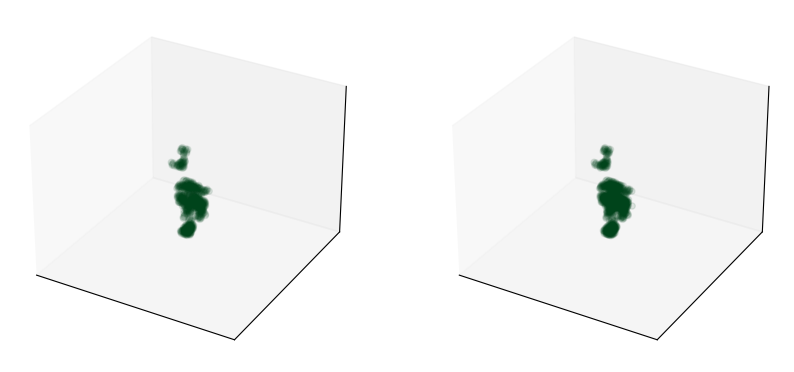

In [20]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121, projection='3d') # 121 indicates: 1 row, 2 columns, first plot
ax2 = fig.add_subplot(122, projection='3d') # 122 indicates: 1 row, 2 columns, second plot

ax1.scatter(coordinates[values==1,0], 
            coordinates[values==1,1], 
            coordinates[values==1,2], 
            c=values[values==1], 
           cmap='Greens',
          vmin=0,
          vmax=1,
          alpha=0.1)
ax1.set_xlim(0,x)
ax1.set_ylim(0,y)
ax1.set_zlim(0,z)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

ax2.scatter(coordinates[recon_values==1,0], 
            coordinates[recon_values==1,1], 
            coordinates[recon_values==1,2], 
            c=recon_values[recon_values==1], 
           cmap='Greens',
          vmin=0,
          vmax=1,
          alpha=0.1)
ax2.set_xlim(0,x)
ax2.set_ylim(0,y)
ax2.set_zlim(0,z)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

plt.savefig(output3D_path)
plt.show()